# House Loan Data Analysis

In [69]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, auc, average_precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

#### Load the dataset that is given to you

In [2]:
loan_df = pd.read_csv('loan_data.csv')
loan_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
loan_df.shape

(307511, 122)

#### Check for null values in the dataset

In [4]:
nan_counts = loan_df.isna().sum()
nan_counts[nan_counts > 0].size

67

There are 67 columns with NaN values.

In [5]:
nan_cols = nan_counts[nan_counts > 0].index.tolist()

In [6]:
loan_df[nan_cols].dtypes.unique()

array([dtype('float64'), dtype('O')], dtype=object)

In [7]:
for col in nan_cols:
    if loan_df[col].dtype == 'float64':
        val = loan_df[col].median()
    elif loan_df[col].dtype == 'O':
        val = loan_df[col].mode()[0]
          
    loan_df[col] = loan_df[col].fillna(val)

In [8]:
loan_df.isna().sum().sum()

0

Now all NaN values got resolved.

#### Print percentage of default to payer of the dataset for the TARGET column

In [9]:
loan_df['TARGET'].value_counts() / loan_df['TARGET'].size * 100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

So we have 92% data with target label as 0 and 8% as 1.

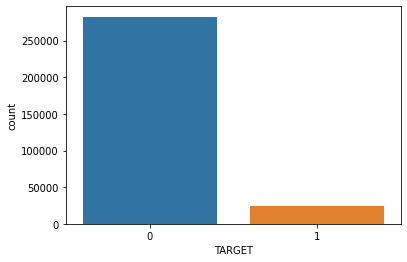

In [10]:
sns.countplot(loan_df['TARGET'])
plt.show()

Lets extract the categorical values.

In [11]:
cat_cols = loan_df.columns[loan_df.dtypes == 'O']
len(cat_cols)

16

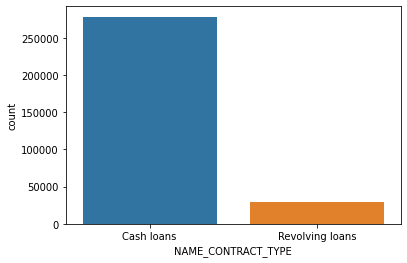

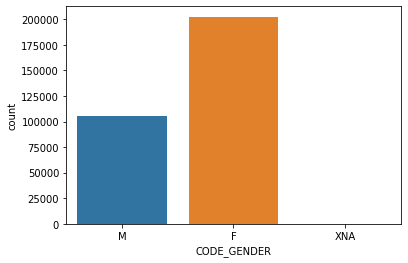

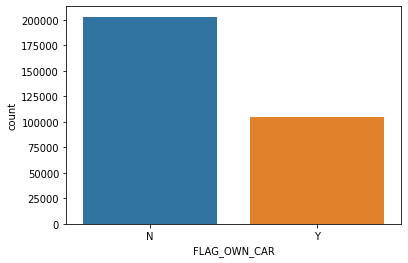

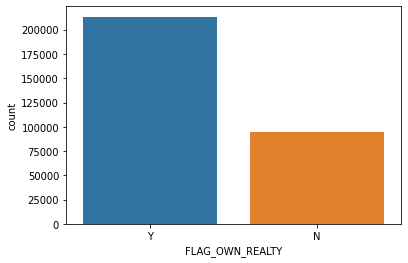

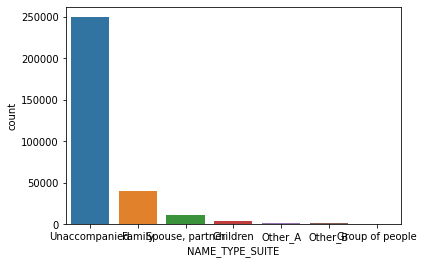

In [12]:
for col in cat_cols[:5]:
    sns.countplot(loan_df[col])
    plt.show()

#### Encode the columns that is required for the model

In [13]:
loan_df_en = pd.get_dummies(loan_df, columns = cat_cols, drop_first=True)

In [14]:
loan_df_en.shape

(307511, 230)

#### Balance the dataset if the data is imbalanced

In [15]:
x = loan_df_en.drop(['TARGET'], axis=1)
y = loan_df_en['TARGET']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(230633, 229)
(76878, 229)
(230633,)
(76878,)


In [17]:
print('Before balancing, train 1:', sum(y_train == 1))
print('Before balancing, train 0:', sum(y_train == 0))

Before balancing, train 1: 18734
Before balancing, train 0: 211899


In [18]:
sm = SMOTE(random_state=0)

x_train_blc, y_train_blc = sm.fit_resample(x_train, y_train)

In [19]:
print('After balancing, train 1:', sum(y_train_blc == 1))
print('After balancing, train 0:', sum(y_train_blc == 0))

After balancing, train 1: 211899
After balancing, train 0: 211899


In [20]:
y_train_blc.shape

(423798,)

#### Plot the balanced data or imbalanced data

Lets plot x_train and x_train_blc. Now we have 229 dimension.

So we can use PCA to get 2D data and can plot it.

In [21]:
pca = PCA(n_components= 2)
x_train_pca = pca.fit_transform(x_train)
x_train_blc_pca = pca.fit_transform(x_train_blc)

In [22]:
print(x_train_pca.shape)
print(x_train_blc_pca.shape)

(230633, 2)
(423798, 2)


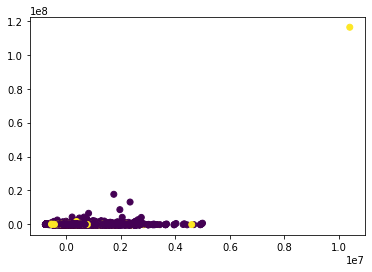

In [23]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c= y_train)
plt.show()

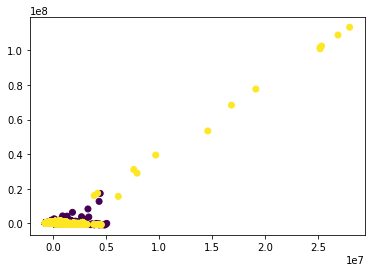

In [24]:
plt.scatter(x_train_blc_pca[:, 0], x_train_blc_pca[:, 1], c= y_train_blc)
plt.show()

Lets find out the important features based on correlation with Target.

In [25]:
col_idx = np.argsort(loan_df_en.corr()['TARGET'])[-7:-1]
corr_cols = loan_df_en.columns[col_idx].tolist()
corr_cols

['CODE_GENDER_M',
 'DAYS_LAST_PHONE_CHANGE',
 'NAME_INCOME_TYPE_Working',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'DAYS_BIRTH']

In [26]:
vals = x_train_blc.loc[:, corr_cols]
vals['TARGET'] = y_train_blc
vals1 = vals[vals['TARGET'] == 0][:1000]
vals2 = vals[vals['TARGET'] == 1][:1000]

vals = pd.concat([vals1, vals2])
vals.shape

(2000, 7)

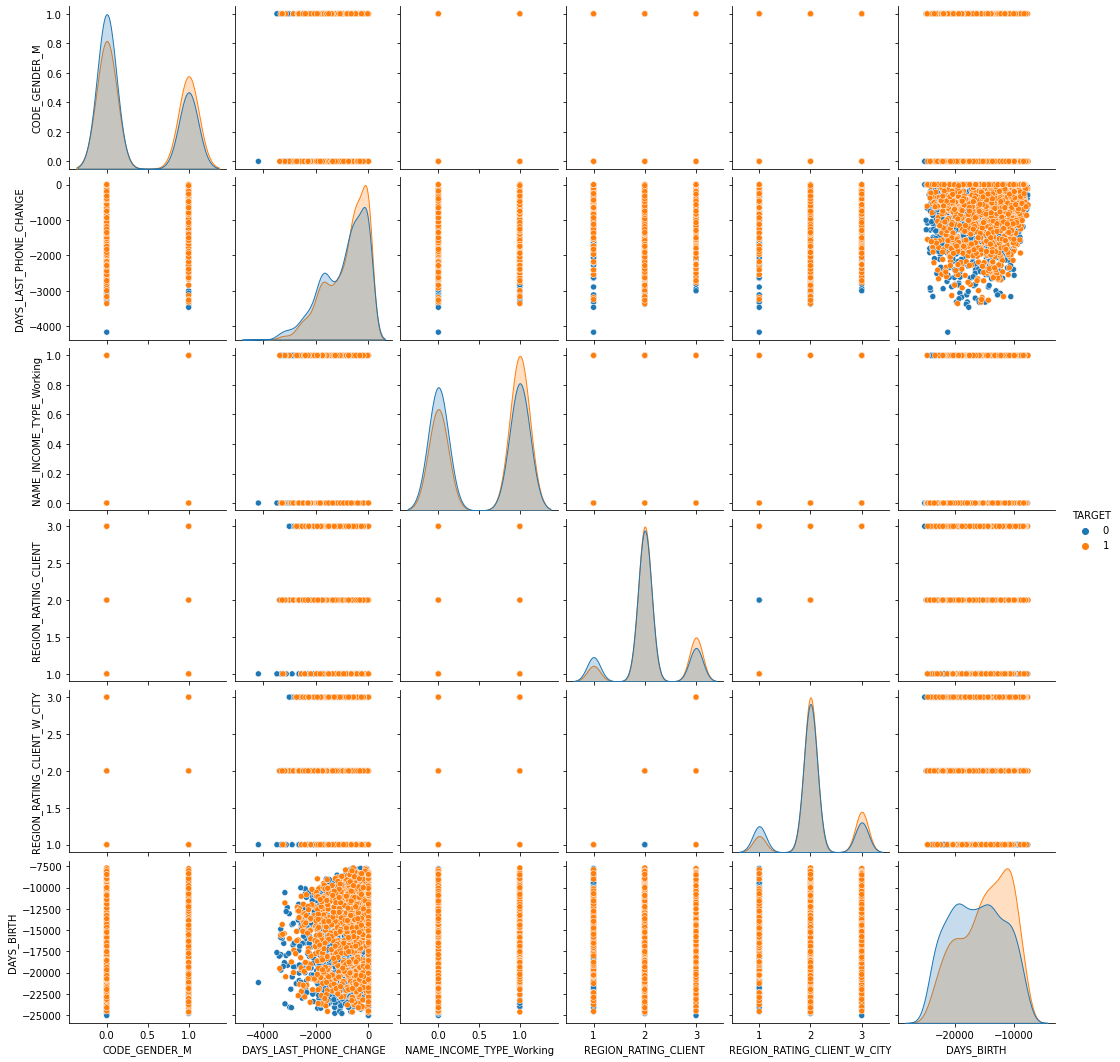

In [27]:
sns.pairplot(vals, hue= 'TARGET')
plt.show()

In [29]:
# Standardize data
sc = StandardScaler()
x_train_blc = sc.fit_transform(x_train_blc)
x_test = sc.transform(x_test)

#### Create DL model

In [40]:
model = Sequential()
model.add(Dense(128, activation= 'tanh', input_shape=(229,), kernel_initializer='he_normal', kernel_regularizer='L2'))
model.add(BatchNormalization())
model.add(Dense(64, activation= 'relu', kernel_initializer='he_normal', kernel_regularizer='L2'))
model.add(BatchNormalization())
model.add(Dense(32, activation= 'relu', kernel_initializer='he_normal', kernel_regularizer='L2'))
model.add(BatchNormalization())
model.add(Dense(1, activation= 'sigmoid'))

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               29440     
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_8 (Batc  (None, 32)              

#### Calculate Sensitivity as a metrice

In [42]:
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.AUC()])

In [43]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [44]:
history = model.fit(
    x_train_blc, y_train_blc,
    validation_data=(x_test, y_test),
    batch_size= 50,
    epochs= 20,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/20
8476/8476 [==============================] - 32s 4ms/step - loss: 0.3198 - auc_2: 0.9640 - val_loss: 0.2840 - val_auc_2: 0.7020
Epoch 2/20
8476/8476 [==============================] - 29s 3ms/step - loss: 0.1847 - auc_2: 0.9691 - val_loss: 0.2787 - val_auc_2: 0.7073
Epoch 3/20
8476/8476 [==============================] - 30s 4ms/step - loss: 0.1818 - auc_2: 0.9692 - val_loss: 0.2753 - val_auc_2: 0.7137
Epoch 4/20
8476/8476 [==============================] - 30s 3ms/step - loss: 0.1813 - auc_2: 0.9692 - val_loss: 0.2772 - val_auc_2: 0.7073
Epoch 5/20
8476/8476 [==============================] - 28s 3ms/step - loss: 0.1812 - auc_2: 0.9691 - val_loss: 0.2732 - val_auc_2: 0.7111
Epoch 6/20
8476/8476 [==============================] - 28s 3ms/step - loss: 0.1805 - auc_2: 0.9694 - val_loss: 0.2776 - val_auc_2: 0.7134
Epoch 7/20
8476/8476 [==============================] - 27s 3ms/step - loss: 0.1799 - auc_2: 0.9695 - val_loss: 0.2857 - val_auc_2: 0.7039
Epoch 8/20
8476/8476 [=====

In [45]:
history = pd.DataFrame(history.history)
history.head()

,loss,auc_2,val_loss,val_auc_2
0,0.319780,0.963956,0.284033,0.702000
1,0.184721,0.969133,0.278740,0.707318
2,0.181829,0.969194,0.275317,0.713744
3,0.181271,0.969211,0.277223,0.707261
4,0.181243,0.969146,0.273222,0.711122


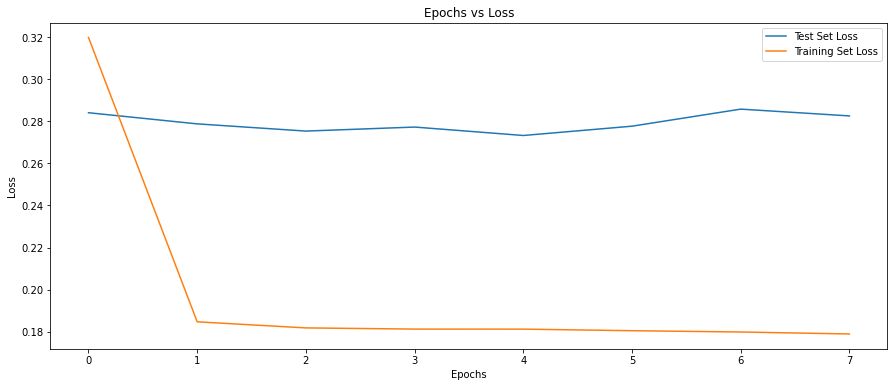

In [46]:
plt.figure(figsize = (15,6))
plt.plot(history.val_loss, label='Test Set Loss')
plt.plot(history.loss, label='Training Set Loss')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

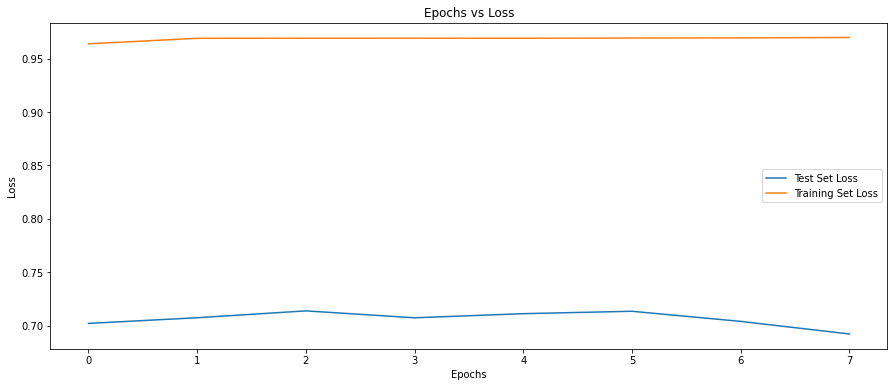

In [48]:
plt.figure(figsize = (15,6))
plt.plot(history.val_auc_2, label='Test Set Loss')
plt.plot(history.auc_2, label='Training Set Loss')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Calculate Sensitivity as a metrice

#### Calculate area under receiver operating characteristics curve

Lets test the model with train and test set and get confusion matrix, sensitivity and auc scores.

In [49]:
y_train_blc_pred = model.predict(x_train_blc)

In [50]:
cm1 = confusion_matrix(y_train_blc, y_train_blc_pred>0.5)
cm1

array([[210168,   1731],
       [ 20480, 191419]])

In [51]:
tn, fp, fn, tp = cm1.ravel()
sensitivity = tp / (tp+fn)
print(sensitivity)

0.9033501809824492


In [52]:
roc_auc_score(y_train_blc, y_train_blc_pred)

0.972218982736536

In [53]:
y_train_pred = model.predict(x_train)

In [54]:
cm2 = confusion_matrix(y_train, y_train_pred>0.5)
cm2

array([[ 51957, 159942],
       [  3394,  15340]])

In [55]:
tn, fp, fn, tp = cm2.ravel()
sensitivity = tp / (tp+fn)
print(sensitivity)

0.8188320700330949


In [56]:
roc_auc_score(y_train, y_train_pred)

0.5375519069958544

In [57]:
y_test_pred = model.predict(x_test)

In [58]:
cm3 = confusion_matrix(y_test, y_test_pred>0.5)
cm3

array([[70207,   580],
       [ 5980,   111]])

In [59]:
tn, fp, fn, tp = cm3.ravel()
sensitivity = tp / (tp+fn)
print(sensitivity)

0.018223608602856673


In [60]:
roc_auc_score(y_test, y_test_pred)

0.6924418195981503

In [71]:
# test auc
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
auc_score = auc(fpr, tpr)
print(auc_score)

0.6924418195981503


In [63]:
_, train_acc = model.evaluate(x_train_blc, y_train_blc, verbose=0)
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Train:{}%, Test: {} %'.format((train_acc*100), (test_acc*100)))

Train:97.2213089466095%, Test: 69.21027898788452 %


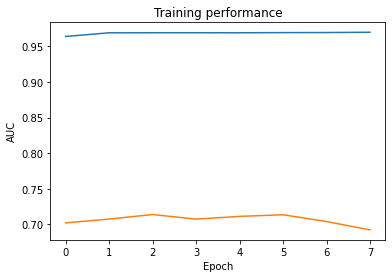

In [65]:
# Plot AUC score
plt.plot(history['auc_2'], label='Train')
plt.plot(history['val_auc_2'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training performance')
plt.show()

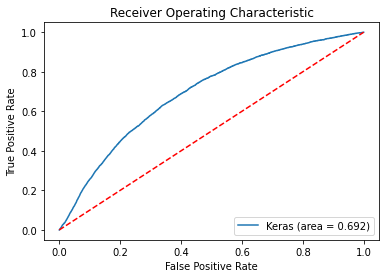

In [66]:
# Plot TPR FPR
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy (Training): 97.221309
ROCAUC Score (Training): 0.972219
PRAUC Score (Training): 0.972219
2403/2403 [==============================] - 3s 1ms/step - loss: 0.2825 - auc_2: 0.6921
Accuracy (Validation): 69.210279
ROCAUC Score (Validation): 0.692442
PRAUC Score (Validation): 0.692442


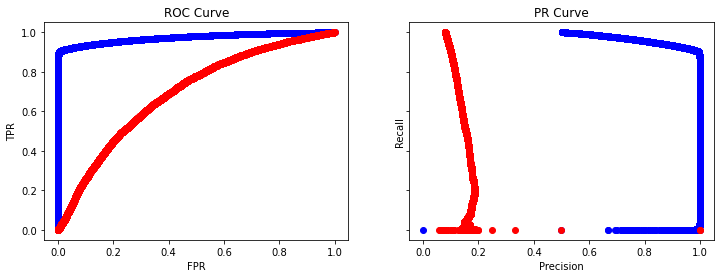

In [72]:
# Plotting ROCAUC and PRAUC
f,(plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
plt1.set_title('ROC Curve')
plt1.set_xlabel('FPR')
plt1.set_ylabel('TPR')
plt2.set_title('PR Curve')
plt2.set_xlabel('Precision')
plt2.set_ylabel('Recall')
# Training set
y_train_predicted = model.predict(x_train_blc).ravel()
fpr, tpr, thresholds = roc_curve(y_train_blc, y_train_predicted)
precision, recall, thresholds = precision_recall_curve(y_train_blc, y_train_predicted)
plt1.scatter(fpr, tpr, color='b')
plt2.scatter(precision, recall,color='b')
print('Accuracy (Training): %f' % (train_acc*100))
print('ROCAUC Score (Training): %f' % roc_auc_score(y_train_blc, y_train_predicted))
print('PRAUC Score (Training): %f' % auc(fpr, tpr))
# Validation set
y_valid_predicted = model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_valid_predicted)
precision, recall, thresholds = precision_recall_curve(y_test, y_valid_predicted)
plt1.scatter(fpr, tpr, color='r')
plt2.scatter(precision, recall,color='r')
acc_score = model.evaluate(x_test, y_test)
print('Accuracy (Validation): %f' % (test_acc*100))
rocauc_score = roc_auc_score(y_test, y_valid_predicted)
print('ROCAUC Score (Validation): %f' % rocauc_score)
prauc_score = auc(fpr, tpr)
print('PRAUC Score (Validation): %f' % prauc_score)
plt.show()